## 1. IMPORT LIBRARIES

In [1]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import cv2

import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 2.LOAD DATA

In [2]:
df= pd.read_csv(r'/kaggle/input/eyepacs-assess/assesment_final/labels.csv')

#### 2.1 EACH CLASS DISTRIBUTION

<Axes: ylabel='quality'>

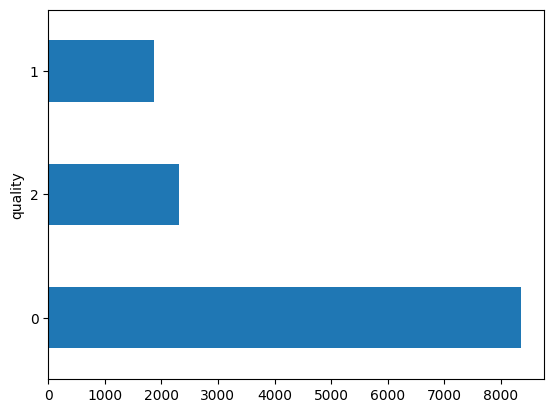

In [3]:
df['quality'].value_counts().plot(kind='barh')

In [4]:
df['filepaths'] = df.apply(lambda row: str("/kaggle/input/eyepacs-assess/assesment_final/images/" + row['image']), axis=1)
df.filepaths[0]

'/kaggle/input/eyepacs-assess/assesment_final/images/10009_left.jpeg'

In [5]:
df = df.dropna()
df = df[['image', 'quality', 'filepaths']]

 ## 3. DATA SPLIT

In [6]:
df, test_df=train_test_split(df, train_size=0.8, stratify=df['quality'], random_state=123)
print ('pre_augmentation_train_df length: ', len(df),'  test_df length: ', len(test_df))
print (df['quality'].value_counts()) 
print (test_df['quality'].value_counts()) 

pre_augmentation_train_df length:  10034   test_df length:  2509
quality
0    6677
2    1856
1    1501
Name: count, dtype: int64
quality
0    1670
2     464
1     375
Name: count, dtype: int64


In [7]:
train_df, valid_df=train_test_split(df, train_size=0.8,stratify=df['quality'], random_state=123)
print ('post_train_df length: ', len(train_df),'  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
print (train_df['quality'].value_counts()) 
print(valid_df['quality'].value_counts())
print (test_df['quality'].value_counts()) 

post_train_df length:  8027   test_df length:  2509   valid_df length:  2007
quality
0    5341
2    1485
1    1201
Name: count, dtype: int64
quality
0    1336
2     371
1     300
Name: count, dtype: int64
quality
0    1670
2     464
1     375
Name: count, dtype: int64


In [8]:
df.head()

,image,quality,filepaths
1069,13431_left.jpeg,2,/kaggle/input/eyepacs-assess/assesment_final/i...
10633,43982_right.jpeg,0,/kaggle/input/eyepacs-assess/assesment_final/i...
12052,851_right.jpeg,0,/kaggle/input/eyepacs-assess/assesment_final/i...
2938,19177_left.jpeg,2,/kaggle/input/eyepacs-assess/assesment_final/i...
6302,30249_right.jpeg,0,/kaggle/input/eyepacs-assess/assesment_final/i...


In [9]:
train_df['quality'] = train_df['quality'].astype('str')
valid_df['quality'] = valid_df['quality'].astype('str')
test_df['quality'] = test_df['quality'].astype('str')

## 4. GENERATORS

In [10]:
height=512
width=512
channels = 3
batch_size = 8
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ('test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    img=img/255
    return img 
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=trgen.flow_from_dataframe( train_df, 
                                    x_col='filepaths',
                                    y_col='quality', 
                                    target_size=img_size, 
                                    class_mode='categorical',
                                    color_mode='rgb', 
                                    shuffle=True, 
                                    batch_size=batch_size)

test_gen=tvgen.flow_from_dataframe(test_df, 
                                   x_col='filepaths', 
                                   y_col='quality', 
                                   target_size=img_size, 
                                   class_mode='categorical',
                                   color_mode='rgb', 
                                   shuffle=False, 
                                   batch_size=test_batch_size)

valid_gen=tvgen.flow_from_dataframe(valid_df, 
                                    x_col='filepaths', 
                                    y_col='quality', 
                                    target_size=img_size, 
                                    class_mode='categorical',
                                    color_mode='rgb', 
                                    shuffle=True, 
                                    batch_size=batch_size)

classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(len(train_gen.labels)/batch_size)

test batch size:  13   test steps:  193
Found 7945 validated image filenames belonging to 3 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 82 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


Found 2489 validated image filenames belonging to 3 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 20 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


Found 1991 validated image filenames belonging to 3 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 16 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


In [11]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='green', fontsize=16)
        plt.axis('off')
    plt.show()

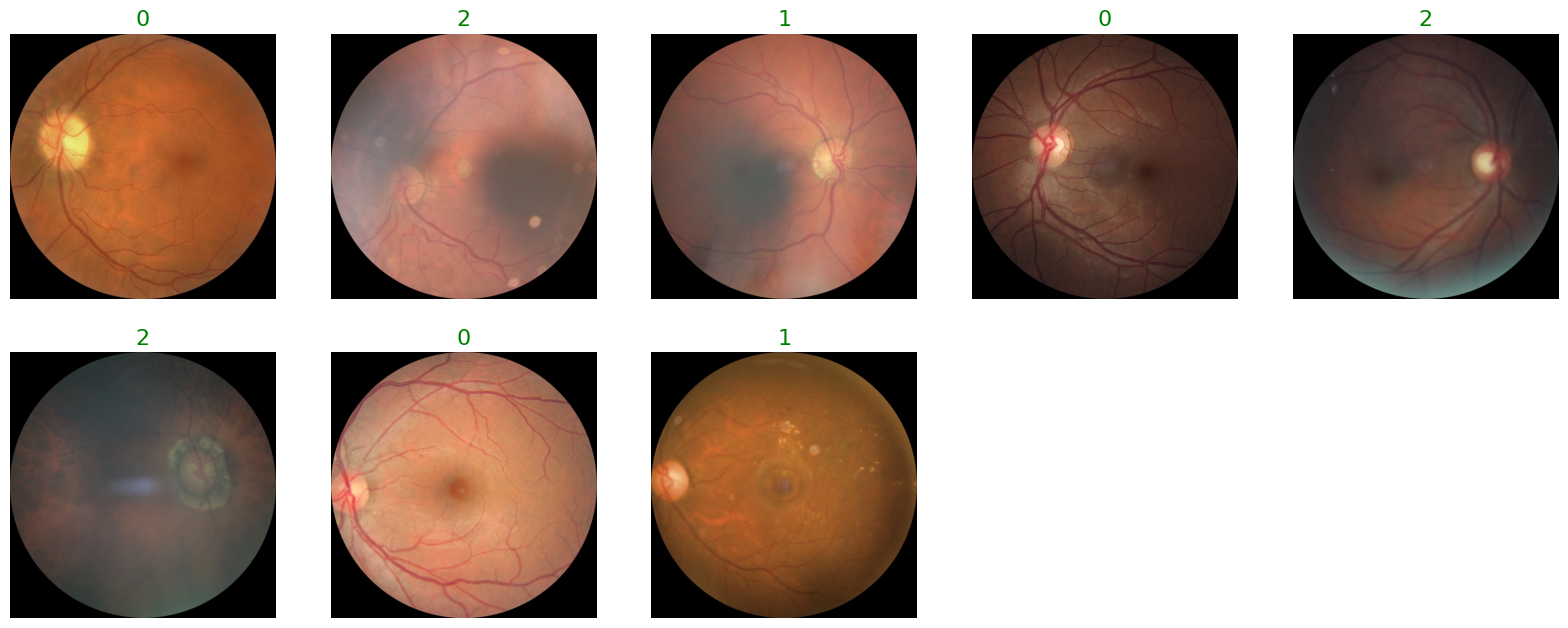

In [12]:
show_image_samples(train_gen)

## 5. CALLBACKS

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import CSVLogger
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

/tmp/ipykernel_26/3096373095.py:25: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## 6. MODEL BUILDING

In [14]:
##############################
# Callbacks
##############################
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-9)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callbacks = [reduce_lr, early_stop]
##############################

## 7. MODEL TRAINING

In [15]:
base_model=tf.keras.applications.DenseNet121(include_top=False, weights=None,input_shape=(512,512,3), pooling='avg') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256,activation='relu')(x)
x=Dropout(rate=0.3, seed=123)(x) 
x = Dense(128,activation='relu')(x)
output=Dense(3, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 518, 518, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 256, 256, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1/conv[0][0]']      

In [17]:
##############################
# Compute Class Weights:
##############################
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(zip(np.unique(train_gen.classes), class_weights))
##############################

In [18]:
##############################
# Callbacks
##############################
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-9)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callbacks = [reduce_lr, early_stop]
##############################

## 8. TRAIN THE MODEL

In [19]:
##############################
### Training Configuration
##############################
epochs = 50
batches = train_steps
##############################
# Model Training
##############################
history = model.fit(
    x=train_gen,
    epochs=epochs,
    steps_per_epoch=batches,  
    verbose=1,
    callbacks=callbacks,
    validation_data=valid_gen,
    class_weight=class_weights,
    shuffle=False,
    initial_epoch=0
)
##############################

Epoch 1/50
993/993 [==============================] - 309s 250ms/step - loss: 0.8152 - accuracy: 0.6879 - val_loss: 0.8100 - val_accuracy: 0.7243 - lr: 1.0000e-04
Epoch 2/50
993/993 [==============================] - 243s 244ms/step - loss: 0.7246 - accuracy: 0.7435 - val_loss: 0.5912 - val_accuracy: 0.7875 - lr: 1.0000e-04
Epoch 3/50
993/993 [==============================] - 242s 244ms/step - loss: 0.6760 - accuracy: 0.7686 - val_loss: 0.8587 - val_accuracy: 0.6881 - lr: 1.0000e-04
Epoch 4/50
993/993 [==============================] - 242s 244ms/step - loss: 0.6103 - accuracy: 0.7959 - val_loss: 0.4096 - val_accuracy: 0.8332 - lr: 1.0000e-04
Epoch 6/50
993/993 [==============================] - 242s 244ms/step - loss: 0.5901 - accuracy: 0.8004 - val_loss: 0.4418 - val_accuracy: 0.8257 - lr: 1.0000e-04
Epoch 7/50
993/993 [==============================] - 241s 243ms/step - loss: 0.5662 - accuracy: 0.8129 - val_loss: 0.4319 - val_accuracy: 0.8302 - lr: 1.0000e-04
Epoch 8/50
993/993 [==

## 9. MODEL PERFORMANCE VISUALIZATION

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

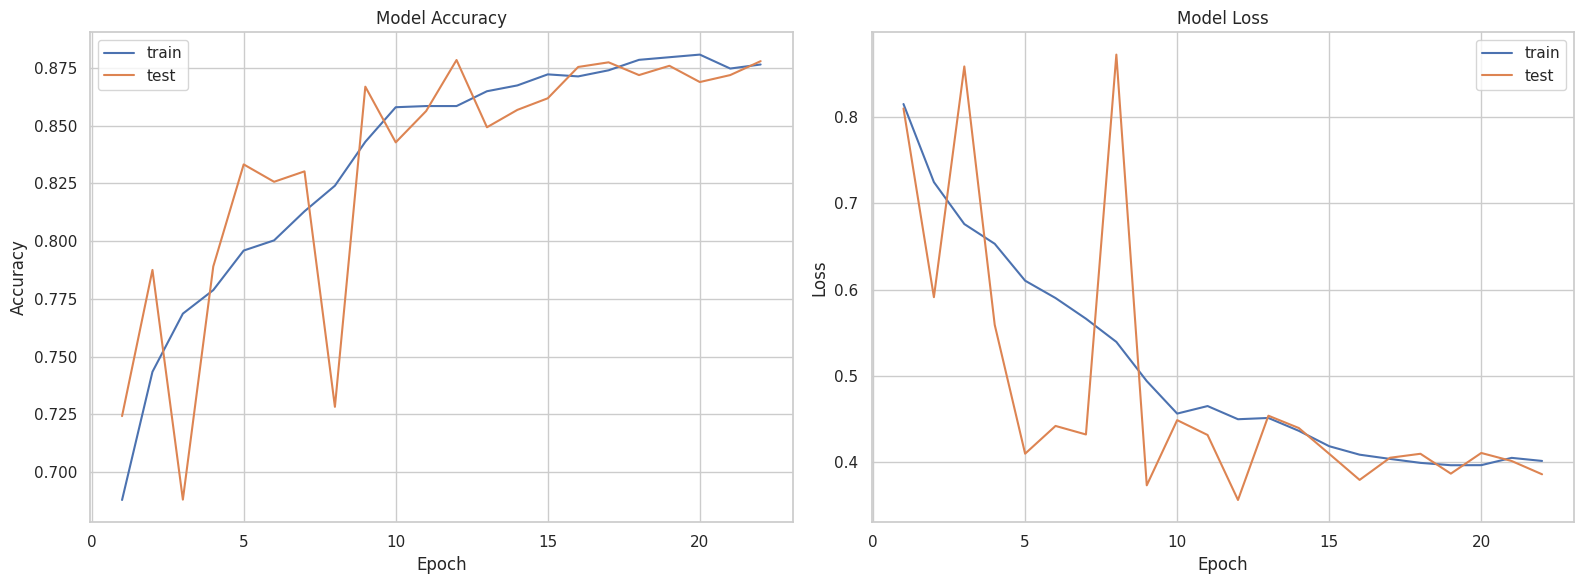

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
####################################
sns.set(style='whitegrid')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.lineplot(x=range(1, len(history.history['accuracy']) + 1), y=history.history['accuracy'], ax=axes[0], label='train')
sns.lineplot(x=range(1, len(history.history['val_accuracy']) + 1), y=history.history['val_accuracy'], ax=axes[0], label='test')
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(loc='upper left')
sns.lineplot(x=range(1, len(history.history['loss']) + 1), y=history.history['loss'], ax=axes[1], label='train')
sns.lineplot(x=range(1, len(history.history['val_loss']) + 1), y=history.history['val_loss'], ax=axes[1], label='test')
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(loc='upper right')
plt.tight_layout()
plt.show()
####################################

192/192 [==============================] - 25s 130ms/step


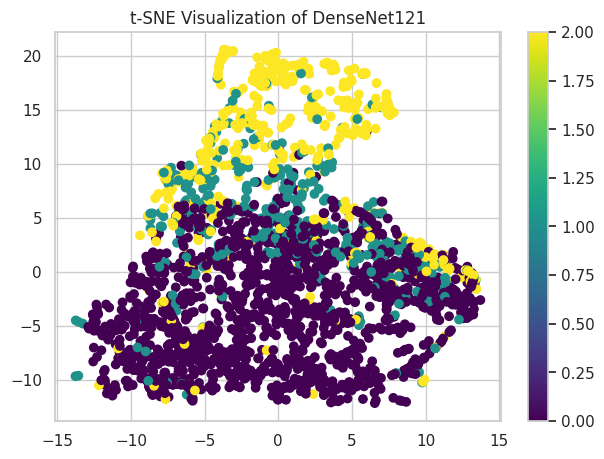

In [27]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

####################################
batch_size = 16
steps = len(test_gen)
features = base_model.predict(test_gen, steps=steps, verbose=1)
features_reshaped = features.reshape((features.shape[0], -1))
tsne = TSNE(n_components=3, random_state=42)
reduced_features = tsne.fit_transform(features_reshaped)
labels = np.concatenate([test_gen[i][1] for i in range(steps)])

plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=np.argmax(labels, axis=1), cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of DenseNet121')
plt.show()

In [28]:
pred = model.predict(test_gen)

192/192 [==============================] - 25s 132ms/step


In [29]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key            
    classes=list(new_dict.values())     
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  
        if pred_index != true_index: 
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))              
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) 
                plot_class.append(value)   
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # Create a confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        length = len(classes)
        if length < 8:
            fig_width = 8
            fig_height = 8
        else:
            fig_width = int(length * 0.5)
            fig_height = int(length * 0.5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

### 9.1 MODEL PERFORMANCE ON TEST DATA

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.96      0.95      0.95      1656
           1       0.62      0.71      0.66       372
           2       0.84      0.78      0.81       461

    accuracy                           0.88      2489
   macro avg       0.81      0.81      0.81      2489
weighted avg       0.89      0.88      0.88      2489



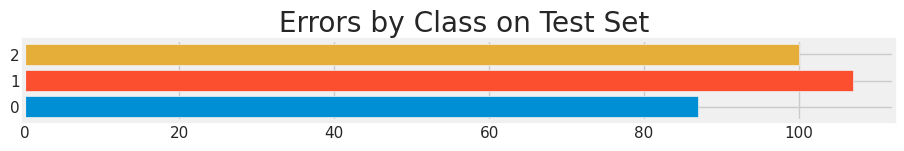

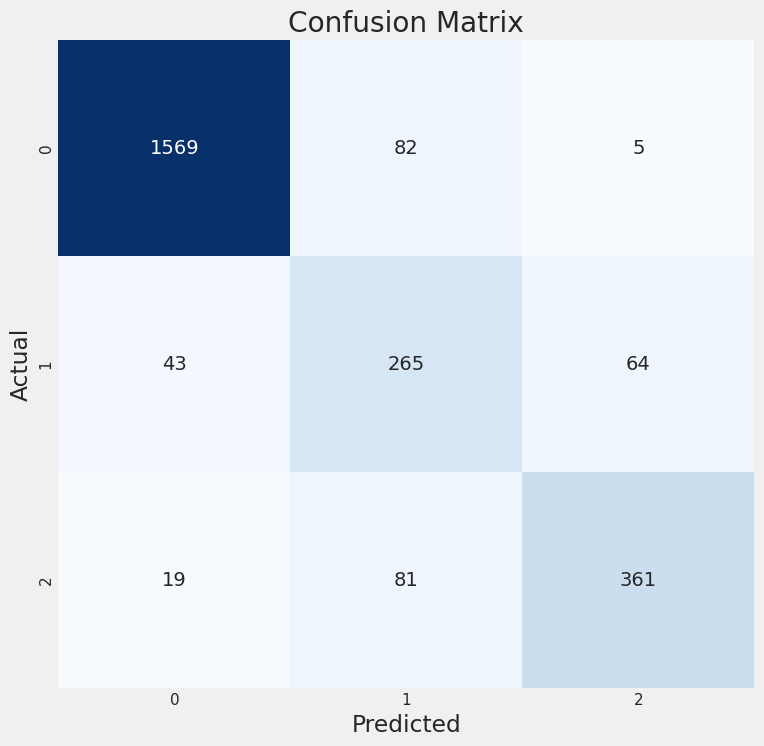

In [30]:
print_code = 0
save_dir = "./"
subject='classes'
print_info( test_gen, pred, print_code, save_dir, subject)